## Simppeli
https://github.com/michalfaber/CarND-Behavioral-Cloning/blob/master/model.py

In [18]:

from tqdm import tqdm_notebook # to print progress in a script (tarviiko?)
import os
import pandas as pd
import numpy as np
import cv2
import json
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, MaxPooling2D, Convolution2D, Lambda, ELU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.layers.core import Dense, Dropout, Activation
import tensorflow as tf
tf.python.control_flow_ops = tf

epochs = 25
batch_size = 128
dataset_dir = "/Users/jussi/Desktop/CarND/data_nd"
image_columns = 32
image_rows = 16
image_channels = 1
side_shift = 0.25


def preproccess_image(image):
    image = (cv2.cvtColor(image, cv2.COLOR_BGR2HSV))[:, :, 1]
    image = image.reshape(160, 320, 1)
    image = cv2.resize(image, (image_columns, image_rows))
    return image


def prepare(data):
    x, y = [], []

    for i in range(len(data)):
        line_data = data.iloc[i]
        y_steer = line_data['steering']
        path_center = line_data['center'].strip()
        path_left = line_data['left'].strip()
        path_right = line_data['right'].strip()

        for path, shift in [(path_center, 0), (path_left, side_shift), (path_right, -side_shift)]:
            # read image
            image_path = os.path.join(dataset_dir, path)
            image = cv2.imread(image_path)

            # preprocess image
            image = preproccess_image(image)

            # add image
            x.append(image)
            y.append(y_steer + shift)

            # add flipped image
            image = image[:, ::-1]
            x.append(image)
            y.append(-(y_steer + shift))

    return np.array(x).astype('float32'), np.array(y).astype('float32')



# comma.ai
# https://srikanthpagadala.github.io/serve/carnd-behavioral-cloning-p3-report.html

def model():
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(image_rows, image_columns, image_channels)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation='elu', name='Conv1'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv2'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv3'))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512, activation='elu', name='FC1'))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1, name='output'))
    model.summary()
    
    return model


if __name__ == '__main__':
    print("Loading images...")

    data = pd.read_csv(os.path.join(dataset_dir, "/Users/jussi/Desktop/CarND/data_nd/driving_log.csv"))

    X_train, y_train = prepare(data)
    X_train, y_train = shuffle(X_train, y_train)
    X_train = np.expand_dims(X_train, axis=3)

    model = model()
    model.compile('adam', 'mean_squared_error', ['mean_squared_error'])
    checkpoint = ModelCheckpoint("model.h5", monitor='val_mean_squared_error', verbose=1,
                                  save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_mean_squared_error', min_delta=0.0001, patience=4,
                                verbose=1, mode='min')
    model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, verbose=1,
                      callbacks=[checkpoint, early_stop], validation_split=0.15, shuffle=True)

# muualla suositeltu
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json.dump(model_json, json_file)
model.save_weights("./model.h5")
print("Saved model to disk")

Loading images...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_8 (Lambda)                (None, 16, 32, 1)     0           lambda_input_8[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 4, 8, 16)      1040        lambda_8[0][0]                   
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 2, 4, 32)      12832       Conv1[0][0]                      
____________________________________________________________________________________________________
Conv3 (Convolution2D)            (None, 1, 2, 64)      51264       Conv2[0][0]                      
_________________________________________________________________________

40983/40983 [==============================] - 8s - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 18/25
40983/40983 [==============================] - 8s - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 19/25
40983/40983 [==============================] - 8s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 20/25
40983/40983 [==============================] - 8s - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 00019: early stopping
Saved model to disk


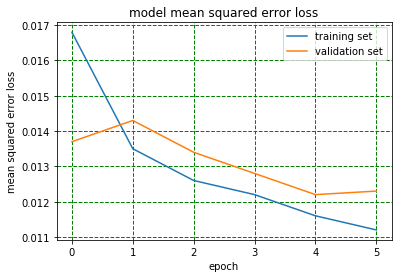

In [23]:
from keras.models import Model
import matplotlib.pyplot as plt

# dict_keys(['loss', 'val_loss'])
loss = [0.0168, 0.0135, 0.0126, 0.0122 , 0.0116, 0.0112] #1,3,5,10,15,20
valid_loss = [0.0137, 0.0143, 0.0134, 0.0128, 0.0122, 0.0123]


## plot the training and validation loss for each epoch
plt.plot(loss)
plt.plot(valid_loss)
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch', )
plt.legend(['training set', 'validation set'], loc='upper right')
plt.grid(color='green', linestyle='--', linewidth=1)
plt.show()